### CCO50- Digital Speech Processing  
# Short Test 4

**Description:** Design an FIR filter (g[n]) of order M = 5 to allow for frequencies above 1500 Hz to pass through, assuming that the input signal to be filtered (x[n]) was sampled at 24000 samples per second. Then, obtain the system transfer function, i.e., the Z-Transform of g[n].

$$

h[n] = \frac{\sin{(\omega_c (n - \frac{M}{2}))}}{\pi (n - \frac{M}{2})}
\\\\
M = 5
\\\\ 
0 \leq n \leq 5
\\\\
\pi = 12kHz
\\\\
\omega_c = 1,5kHz = \frac{\pi}{8}
\\\\\\
$$
To high-pass filter, let use the complement of the $\omega_c$ value
$$
    \omega_c = 1 - \omega_c = \frac{7\pi}{8}

$$

First, calculate a low-pass filter $h[]$ using the $\omega_c$ complement:
$$
h[0] = \frac{\sin{(\frac{7\pi}{8} (0 - \frac{5}{2}))}}{\pi (0 - \frac{5}{2})} = 0,0707374
\\
h[1] = \frac{\sin{(\frac{7\pi}{8} (1 - \frac{5}{2}))}}{\pi (1 - \frac{5}{2})} = -0,17644333 
\\
h[2] = \frac{\sin{(\frac{7\pi}{8} (2 - \frac{5}{2}))}}{\pi (2 - \frac{5}{2})} = 0,6243873
\\
h[3] = \frac{\sin{(\frac{7\pi}{8} (3 - \frac{5}{2}))}}{\pi (3 - \frac{5}{2})} = 0,6243873
\\
h[4] = \frac{\sin{(\frac{7\pi}{8} (4 - \frac{5}{2}))}}{\pi (4 - \frac{5}{2})} = -0,17644333
\\
h[5] = \frac{\sin{(\frac{7\pi}{8} (5 - \frac{5}{2}))}}{\pi (5 - \frac{5}{2})} = 0,0707374

$$

$$h = ( +0.0707,  -0.176,  +0.624,   +0.624,  -0.176,  +0.0707 )$$

Then, reverse the filter and invert the signal of every odd index

$$g = ( +0.0707, +0.176, +0.624, -0.624, -0.176, -0.0707)$$


Z-Transform transforms a n-sample long time-domain signal $x[n]$ to the frequency-domain. It is defined as

$$
Z(x[n]) = X[z] = \sum_{k=0}^{N-1}{x_k \cdot z^{-k}}
$$

So, for our $g[]$ the Z-Transform is 
$$
G[z] = 0.0707 + 0.176 z^{-1} + 0.624 z^{-2} - 0.624 z^{-3} - 0.176 z^{-4} - 0.0707 z^{-5}

$$

Checking the high pass filter:

for $z = e^{j\omega} = \cos(\omega) + j \cdot \sin(\omega)$ then 

for $\omega = 0$,  $z = 1$  and for $\omega = \pi$, $z = -1$

$G[1] = 0.0707 + 0.176 + 0.624 -0.624 -0.176 -0.0707 = 0$

$G[-1] = 0.0707 -0.176 + 0.624 + 0.624 - 0.176 + 0.0707 = 1.0374$

##### Implementing the filter in python, based on the low-pass filter implemented in the previous ST

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyaudio

In [3]:
def low_pass_filter(cutoff, sample_rate, M=5):
    nyq = sample_rate / 2
    omega = cutoff / nyq
    h = np.zeros(M+1)
    for n in range(M+1):
        if n == (M/2):
            h[n] = 1.0
        else:
            h[n] = (np.sin(np.pi * omega * (n - (M/2)))/(np.pi * (n - (M/2))))
    return h

In [4]:
def high_pass_filter(cutoff, sample_rate, M=5):
    if M % 2 == 0:
        M -= 1
    cutoff = sample_rate / 2 - cutoff
    g = low_pass_filter(cutoff, sample_rate, M)
    g = np.array([-val if i % 2 != 0 else val for i, val in enumerate(g)])
    return g

In [5]:
g = high_pass_filter(1500, 24000, 5)
print(g)

[ 0.0707374   0.17644333  0.6243873  -0.6243873  -0.17644333 -0.0707374 ]


##### Implementing the Z-Transform in python

In [6]:
def z_transform(x, num_points=1000):
    omega = np.linspace(0, np.pi, num_points)
    z = np.exp(1j * omega)
    X_z = np.zeros_like(z, dtype=complex)
    N = len(x)
    for k in range(N):
        X_z += x[k] * z**(-k)
    return omega, X_z

In [ ]:
def plot_z_transform(omega, G_z, name = "G[z]"):
    plt.plot(omega, np.abs(G_z))
    plt.title('Z-Transform of {name}'.format(name=name))
    plt.xlabel('Frequency (omega)')
    plt.ylabel('G(z)')
    plt.grid()
    plt.tight_layout()
    plt.show()


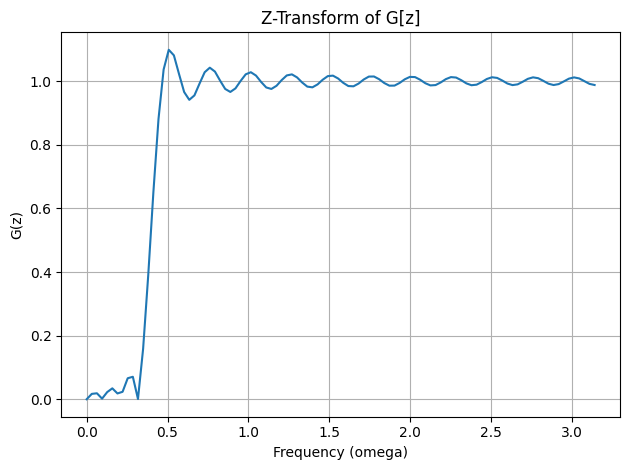

In [25]:
g = high_pass_filter(1500, 24000, 50)
omega, G_z = z_transform(g, 100)
plot_z_transform(omega, G_z)

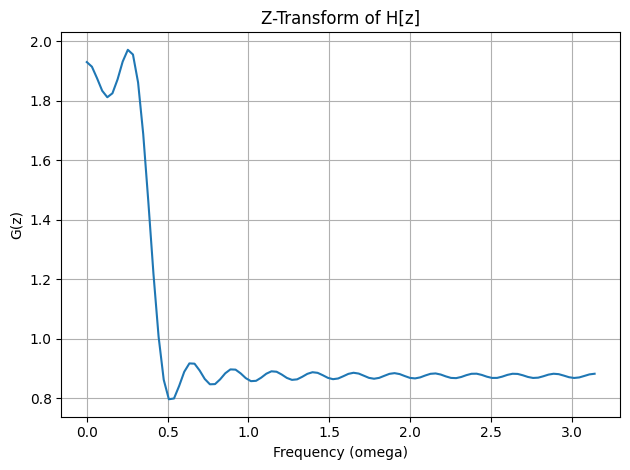

In [26]:
h = low_pass_filter(1500, 24000, 50)
omega, H_z = z_transform(h, 100)
plot_z_transform(omega, H_z, name = "H[z]")

### Extra: generating waves and filtering them

In [10]:
#defining util methods
def play_signal(signal, sample_rate=44100):
    p = pyaudio.PyAudio()

    stream = p.open(format=pyaudio.paFloat32,
                    channels=1,
                    rate=sample_rate,
                    output=True)

    stream.write(signal.tobytes())

    stream.stop_stream()
    stream.close()

    p.terminate()

def plot_waveform(wave, label, title):
    plt.figure(figsize=(10, 4))
    plt.plot(wave, label=label)
    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid()
    plt.show()

In [11]:
# generating an Am7 chord waves
sample_rate = 1200 # using a lower sample rate for less noisy results and more clarity
seconds = 2
octave = 1 # 1 for central octave, to lower pitch use 1/octave
s_A = (np.sin(2 * np.pi * np.arange(sample_rate * seconds) * 440 * octave / sample_rate)).astype(np.float32)
s_C = (np.sin(2 * np.pi * np.arange(sample_rate * seconds) * 256.63 * octave / sample_rate)).astype(np.float32)
s_E = (np.sin(2 * np.pi * np.arange(sample_rate * seconds) * 329.63 * octave / sample_rate)).astype(np.float32)
s_G = (np.sin(2 * np.pi * np.arange(sample_rate * seconds) * 392 * octave / sample_rate)).astype(np.float32)
s_Am7 = s_A + s_C + s_E + s_G
s_Am7 /= np.max(np.abs(s_Am7))  # Normalize the signal

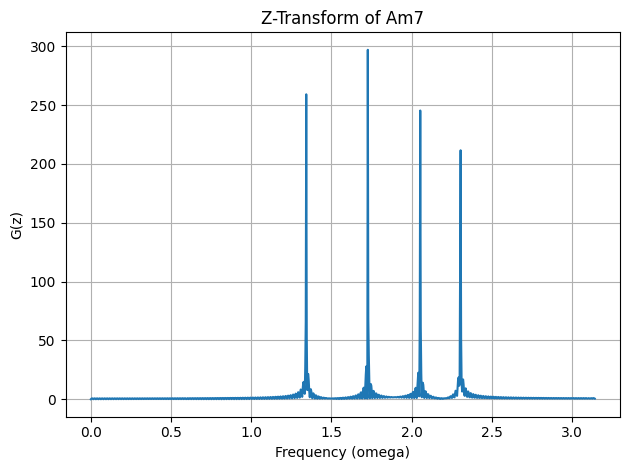

In [23]:
omega, S_z = z_transform(s_Am7, 1000)
plot_z_transform(omega, S_z, name = "Am7")
play_signal(s_Am7, sample_rate)

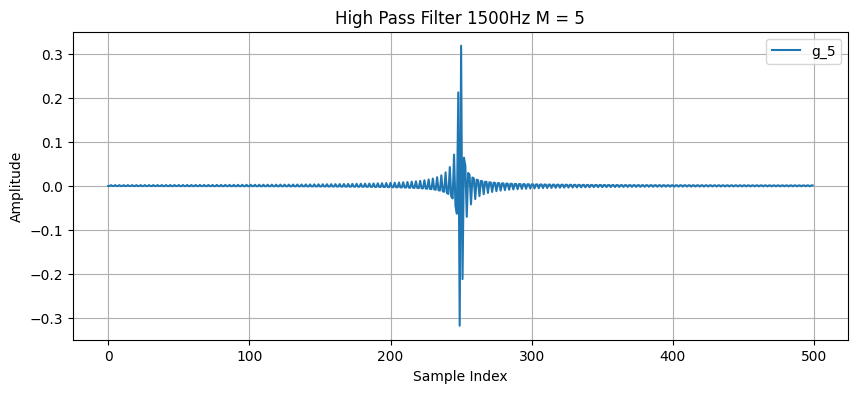

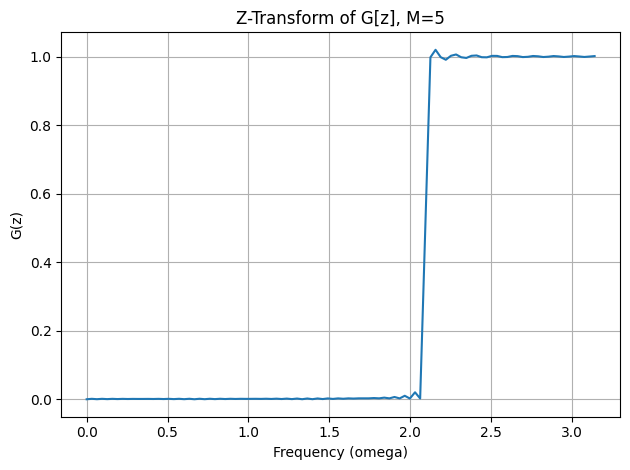

In [31]:
g_5 = high_pass_filter(2000, sample_rate, 500)
plot_waveform(g_5, "g_5", "High Pass Filter 1500Hz M = 5")
omega, G_z = z_transform(g_5, 100)
plot_z_transform(omega, G_z, name = "G[z], M=5")

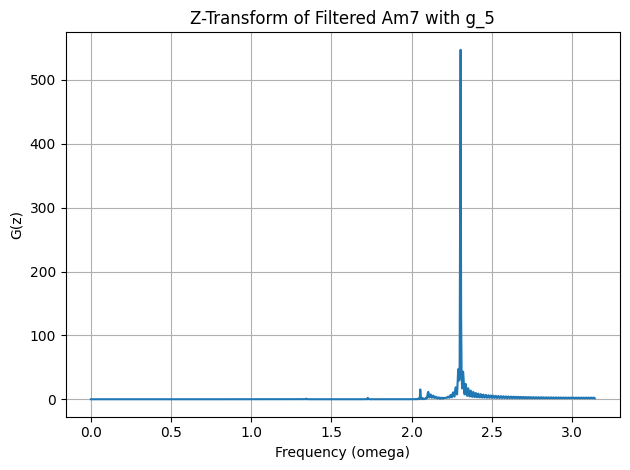

In [32]:
filtered_Am7_g5 = np.convolve(s_Am7, g_5)
filtered_Am7_g5 /= np.max(np.abs(filtered_Am7_g5))  # Normalize the signal
omega, G_z = z_transform(filtered_Am7_g5, 1000)
plot_z_transform(omega, G_z, name = "Filtered Am7 with g_5")
play_signal(filtered_Am7_g5, sample_rate)



**Author:** Matheus Sinto Novaes <br>
**E-mail:** matheus.sinto@unesp.br

**Course:** Digital Speech Processing <br>
**Professor:** Dr. Eng. Rodrigo Capobianco Guido <br>
**Date:** March 17 2025
